# Lab 02 : Variational AutoEncoders (VAE) for MNIST Images -- solution


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5242_2025_codes/labs_lecture08/lab02_vae_image'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time
import random

# Libraries
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device= torch.device("cuda") # use GPU
else:
    device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda


### MNIST dataset 

In [3]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
print(train_data.size())

torch.Size([60000, 28, 28])


### VAE with Transformers

The VAE encoder is designed as follows:
* It begins with a convolutional layer that reduces the input image size from 1 x n x n (grayscale) to d x n/2 x n/2, where d is the hidden dimension. 
* A second convolutional layer further downsamples the feature map from d x n/2 x n/2 to d x n/4 x n/4.
* This is followed by a linear layer that flattens the output to a vector of size d.
* Two additional linear layers are used to produce dz-dimensional vectors for the mean and variance of the Gaussian distribution. 
* 2D batch normalization layer and layer normalization are applied before ReLU activation function. 
* The final output of the encoder is a latent vector z, which is sampled from the learned Gaussian distribution.

The VAE decoder reconstructs the image from the latent representation using a symmetric process:
* It starts with two linear layers that map the latent vector z to a feature map of size d x n/4 x n/4. 
* The decoder then applies two transposed convolutional layers to upsample the feature map from d x n/4 x n/4 to d x n/2 x n/2 and finally to the original image size of 1 x n x n. 
* The reconstructed image, x_hat, is obtained by applying a sigmoid activation function, ensuring the pixel values are constrained to the range [0,1].

Hints: You may use PyTorch modules `nn.Conv2d`, `nn.ConvTranspose2d`, `nn.BatchNorm2d`, `nn.LayerNorm`, `torch.randn`, and `torch.sigmoid`.


In [4]:
# Global constants
n = train_data.size(1) # n : nb of pixels along each spatial dimension
dz = 36 # dz : latent dimension
d = 256 # d : hidden dimension
b = 250 # b : batch size


In [5]:
# Define  VAE architecture
class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Encoder x => z
        self.conv1_enc = nn.Conv2d(1, d, kernel_size=4, padding=1, stride=2) #  1 x 28 x 28 --> d x 14 x 14
        self.bn1_enc = nn.BatchNorm2d(d)
        self.conv2_enc = nn.Conv2d(d, d, kernel_size=4, padding=1, stride=2) #  d x 14 x 14 --> d x 7 x 7
        self.bn2_enc = nn.BatchNorm2d(d)
        self.linear_q = nn.Linear(d*(n//4)**2, d)
        self.ln = nn.LayerNorm(d)
        self.linear_q_mu     = nn.Linear(d, dz)
        self.linear_q_logvar = nn.Linear(d, dz)

        # Decoder z => x
        self.linear1_dec = nn.Linear(dz, d)
        self.ln_dec = nn.LayerNorm(d)
        self.linear2_dec = nn.Linear(d, d*(n//4)**2)
        self.conv1_dec = nn.ConvTranspose2d(d, d, kernel_size=4, padding=1, stride=2) #  d x 7 x 7 --> d x 14 x 14
        self.bn1_dec = nn.BatchNorm2d(d)
        self.conv2_dec = nn.ConvTranspose2d(d, 1, kernel_size=4, padding=1, stride=2) #  d x 14 x 14 --> 1 x 28 x 28
        
    def forward(self, x, train=True): 
        
        if train:
            # Encoder x => z
            h = x.unsqueeze(1) # [b, 1, n, n]
            h = self.conv1_enc(h) # [b, d, n/2, n/2]
            h = self.bn1_enc(h) # [b, d, n/2, n/2]
            h = torch.relu(h)
            h = self.conv2_enc(h) # [b, d, n/4, n/4]  
            h = self.bn2_enc(h) # [b, d, n/4, n/4]  
            h = torch.relu(h) 
            h = h.view(x.size(0),-1) # [b, d*(n/4)**2]
            h = self.linear_q(h) # [b, d]
            h = self.ln(h) # [b, d]
            h = torch.relu(h)
            q_mu = self.linear_q_mu(h) # [b, dz]
            q_logvar = self.linear_q_logvar(h) # [b, dz]
            q_std = torch.exp(0.5*q_logvar) # [b, dz]
            eps = torch.randn_like(q_std) # [b, dz]
            z = q_mu + eps * q_std # [b, dz]
        else:
            # Sample unit Normal distribution
            z = torch.Tensor(x.size(0), dz).normal_(mean=0.0, std=1.0).to(device) # [b, dz]
            q_mu, q_logvar = _, _
            
        # Decoder z => x
        h = self.linear1_dec(z) # [b, d]
        h = self.ln_dec(h) # [b, d]
        h = torch.relu(h)
        h = self.linear2_dec(h) # [b, d*(n/4)**2]
        h = h.view(h.size(0),d,n//4,n//4) # [b, d, n/4, n/4]
        h = self.conv1_dec(h) # [b, d, n/2, n/2]
        h = self.bn1_dec(h) # [b, d, n/2, n/2]
        h = torch.relu(h)
        h = self.conv2_dec(h) # [b, 1, n, n]
        x_hat = torch.sigmoid(h.squeeze()) # [b, n, n]
        
        return x_hat, q_mu, q_logvar
    
    
# Instantiate the network
net = VAE()
net = net.to(device)
print(net)
utils.display_num_param(net) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
idx = torch.LongTensor(b).random_(0,60000)
batch_images = train_data[idx,:,:].to(device) # [b, n, n]
print(batch_images.size())
optimizer.zero_grad()
x_hat, q_mu, q_logvar = net(batch_images) # [b, n, n], [b, dz], [b, dz]
print(x_hat.size())
# loss
p_x = batch_images # we assume that images are Bernoulli distribution
p_xz = x_hat       # we do not perform Bernoulli sampling
loss_data =  nn.BCELoss()(p_xz, p_x)
loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
loss = 10* loss_data + loss_KL
loss.backward()
optimizer.step()


VAE(
  (conv1_enc): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1_enc): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_enc): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2_enc): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_q): Linear(in_features=12544, out_features=256, bias=True)
  (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear_q_mu): Linear(in_features=256, out_features=36, bias=True)
  (linear_q_logvar): Linear(in_features=256, out_features=36, bias=True)
  (linear1_dec): Linear(in_features=36, out_features=256, bias=True)
  (ln_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear2_dec): Linear(in_features=256, out_features=12544, bias=True)
  (conv1_dec): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1_dec): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

There are 8571977 (8.57 million) parameters in this neural network
epoch= 0 	 time= 0.05073668956756592 min 	 lr= 0.0003 	 loss= 0.2694499967992306
epoch= 1 	 time= 0.10089768568674723 min 	 lr= 0.0003 	 loss= 0.22691709265112878
epoch= 2 	 time= 0.15167715549468994 min 	 lr= 0.0003 	 loss= 0.21766494497656821
epoch= 3 	 time= 0.20204610427220662 min 	 lr= 0.0003 	 loss= 0.21291778042912482
epoch= 4 	 time= 0.25234731833140056 min 	 lr= 0.0003 	 loss= 0.20978200306495032
epoch= 5 	 time= 0.303163214524587 min 	 lr= 0.0003 	 loss= 0.20772606283426284
epoch= 6 	 time= 0.3537773847579956 min 	 lr= 0.0003 	 loss= 0.20613201156258584
epoch= 7 	 time= 0.4039724111557007 min 	 lr= 0.0003 	 loss= 0.20506761014461516
epoch= 8 	 time= 0.45438305536905926 min 	 lr= 0.0003 	 loss= 0.20418694689869882
epoch= 9 	 time= 0.5047219276428223 min 	 lr= 0.0003 	 loss= 0.20341725106040637
epoch= 10 	 time= 0.555061415831248 min 	 lr= 0.0003 	 loss= 0.20279816582798957
epoch= 11 	 time= 0.6054950912793478 m

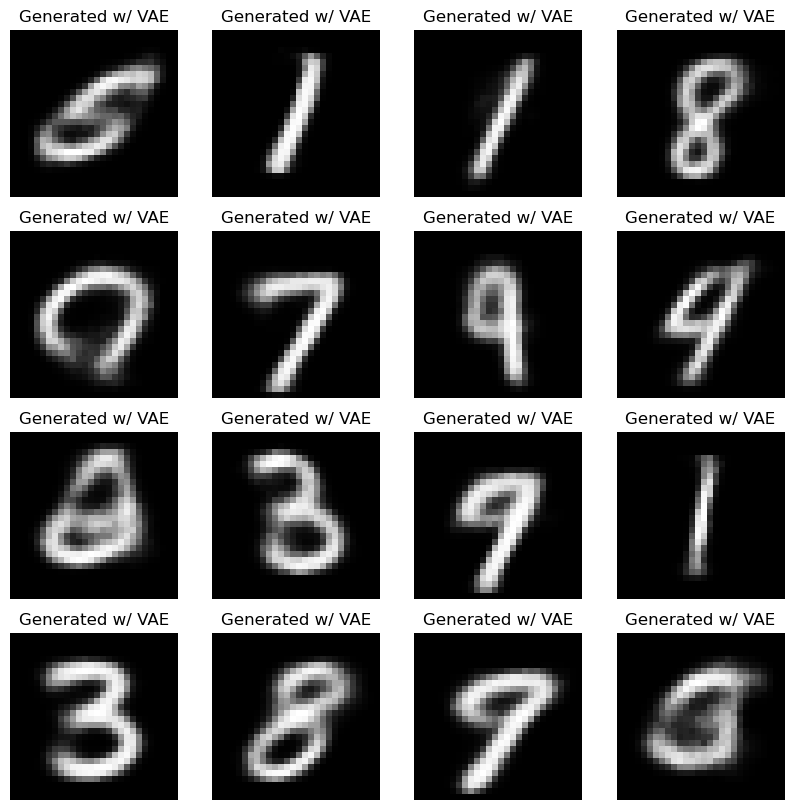

epoch= 21 	 time= 1.121563728650411 min 	 lr= 0.0003 	 loss= 0.19797106752792995
epoch= 22 	 time= 1.1721083045005798 min 	 lr= 0.0003 	 loss= 0.19762891670068106
epoch= 23 	 time= 1.2226521730422975 min 	 lr= 0.0003 	 loss= 0.1972084326048692
epoch= 24 	 time= 1.2732964078585307 min 	 lr= 0.0003 	 loss= 0.19709415093064309
epoch= 25 	 time= 1.3239067196846008 min 	 lr= 0.0003 	 loss= 0.19691171631217003
epoch= 26 	 time= 1.3744508107503255 min 	 lr= 0.0003 	 loss= 0.1965835237503052
epoch= 27 	 time= 1.4251811106999714 min 	 lr= 0.0003 	 loss= 0.19624699925382932
epoch= 28 	 time= 1.4757834196090698 min 	 lr= 0.0003 	 loss= 0.19614212329188982
epoch= 29 	 time= 1.5265438675880432 min 	 lr= 0.0003 	 loss= 0.195791102151076
epoch= 30 	 time= 1.5771008690198263 min 	 lr= 0.0003 	 loss= 0.19567021533846854
epoch= 31 	 time= 1.6279110789299012 min 	 lr= 0.0003 	 loss= 0.19558903614679973
epoch= 32 	 time= 1.678618812561035 min 	 lr= 0.0003 	 loss= 0.19533753087123235
epoch= 33 	 time= 1.72

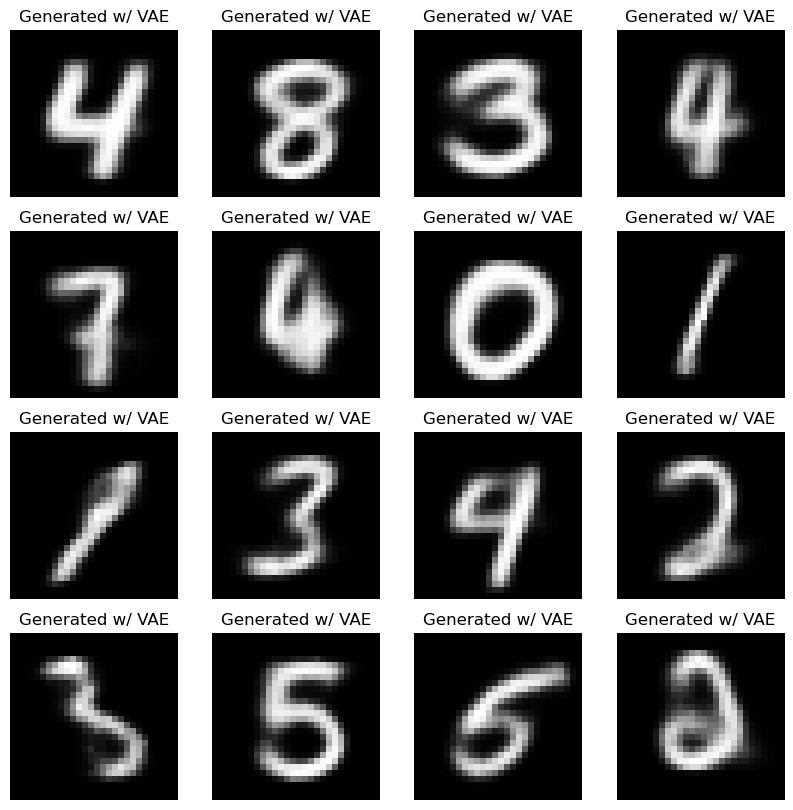

epoch= 41 	 time= 2.147667121887207 min 	 lr= 0.0003 	 loss= 0.19417555938164394
epoch= 42 	 time= 2.198210831483205 min 	 lr= 0.0003 	 loss= 0.19413935919602712
epoch= 43 	 time= 2.2488041202227276 min 	 lr= 0.0003 	 loss= 0.19388521273930867
epoch= 44 	 time= 2.299539891878764 min 	 lr= 0.0003 	 loss= 0.19377741570274035
epoch= 45 	 time= 2.350192991892497 min 	 lr= 0.0003 	 loss= 0.19370680431524911
epoch= 46 	 time= 2.4008586208025613 min 	 lr= 0.0003 	 loss= 0.19373349676529567
epoch= 47 	 time= 2.451674004395803 min 	 lr= 0.0003 	 loss= 0.19350421051184336
epoch= 48 	 time= 2.502388922373454 min 	 lr= 0.0003 	 loss= 0.19334594920277595
epoch= 49 	 time= 2.553004546960195 min 	 lr= 0.0003 	 loss= 0.1933247385919094
epoch= 50 	 time= 2.603621264298757 min 	 lr= 0.0003 	 loss= 0.19336293518543243
epoch= 51 	 time= 2.654215641816457 min 	 lr= 0.0003 	 loss= 0.193143806407849
epoch= 52 	 time= 2.704787043730418 min 	 lr= 0.0003 	 loss= 0.1931637541949749
epoch= 53 	 time= 2.7553004542

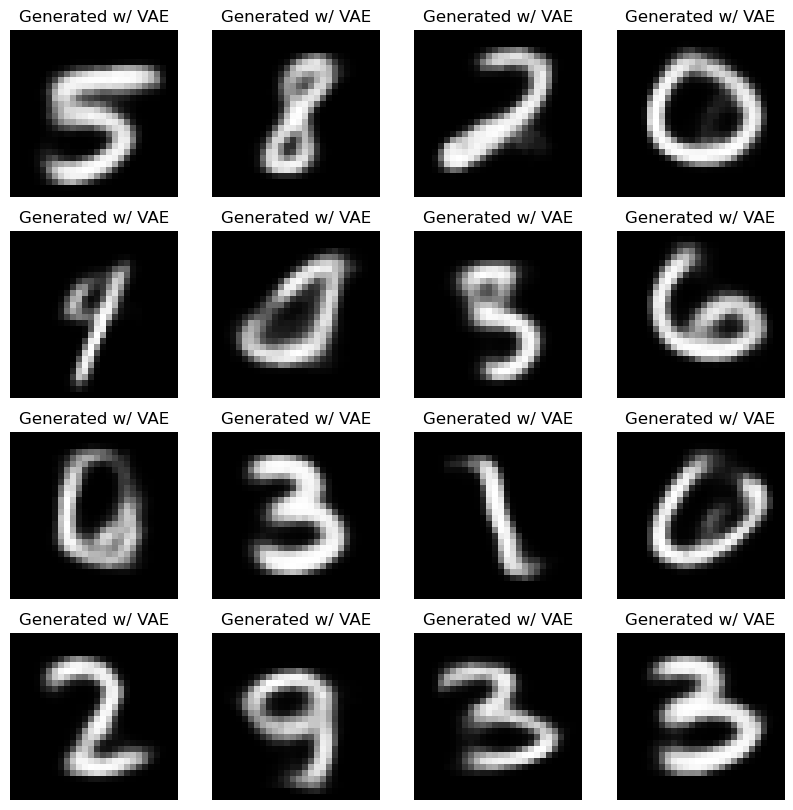

epoch= 61 	 time= 3.171011435985565 min 	 lr= 0.0003 	 loss= 0.19248978366454442
epoch= 62 	 time= 3.2217380444208783 min 	 lr= 0.0003 	 loss= 0.1923596250017484
epoch= 63 	 time= 3.272222312291463 min 	 lr= 0.0003 	 loss= 0.19233946313460668
epoch= 64 	 time= 3.322858512401581 min 	 lr= 0.0003 	 loss= 0.19220016186436018
epoch= 65 	 time= 3.373507523536682 min 	 lr= 0.0003 	 loss= 0.19223133946458498
epoch= 66 	 time= 3.4240546067555746 min 	 lr= 0.0003 	 loss= 0.19209546094139418
epoch= 67 	 time= 3.474600593249003 min 	 lr= 0.0003 	 loss= 0.1921414230267207
epoch= 68 	 time= 3.5250781655311583 min 	 lr= 0.0003 	 loss= 0.19200401683648427
epoch= 69 	 time= 3.5755727251370746 min 	 lr= 0.0003 	 loss= 0.1919412997364998
epoch= 70 	 time= 3.626202126344045 min 	 lr= 0.0003 	 loss= 0.1918759186565876
epoch= 71 	 time= 3.676746602853139 min 	 lr= 0.0003 	 loss= 0.1918146968384584
epoch= 72 	 time= 3.727288003762563 min 	 lr= 0.0003 	 loss= 0.19179530461629232
epoch= 73 	 time= 3.777832929

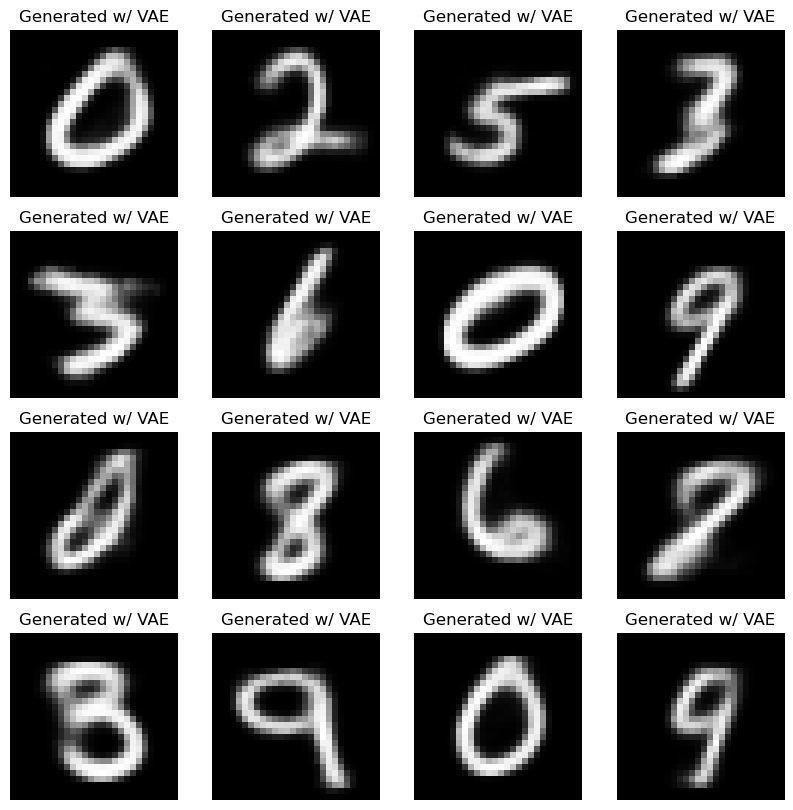

epoch= 81 	 time= 4.196226418018341 min 	 lr= 0.0003 	 loss= 0.19151148170232773
epoch= 82 	 time= 4.246842380364736 min 	 lr= 0.0003 	 loss= 0.19138408347964286
epoch= 83 	 time= 4.2976586302121484 min 	 lr= 0.0003 	 loss= 0.19137920339902242
epoch= 84 	 time= 4.348463269074758 min 	 lr= 0.0003 	 loss= 0.19131327619155247
epoch= 85 	 time= 4.399273431301117 min 	 lr= 0.0003 	 loss= 0.19141664842764536
epoch= 86 	 time= 4.450101419289907 min 	 lr= 0.0003 	 loss= 0.19138631651798885
epoch= 87 	 time= 4.500893465677897 min 	 lr= 0.0003 	 loss= 0.19118740563591322
epoch= 88 	 time= 4.551704128583272 min 	 lr= 0.0003 	 loss= 0.19126493458946545
epoch= 89 	 time= 4.602513043085734 min 	 lr= 0.0003 	 loss= 0.19099058364828428
epoch= 90 	 time= 4.6533699830373125 min 	 lr= 0.0003 	 loss= 0.19121818433205287
epoch= 91 	 time= 4.704187186559041 min 	 lr= 0.0003 	 loss= 0.19108589321374894
epoch= 92 	 time= 4.754875830809275 min 	 lr= 0.0003 	 loss= 0.19115519717335702
epoch= 93 	 time= 4.805653

In [6]:
# Training loop
net = VAE()
net = net.to(device)
utils.display_num_param(net) 

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.AdamW(net.parameters(), lr=init_lr)

nb_batch = 100 
b = 200  # Batch size

start = time.time()
for epoch in range(nb_batch):

    running_loss = 0.0
    num_batches = 0
    
    shuffled_indices = torch.randperm(60000)
    
    for count in range(0,60000,b):
        
        # FORWARD AND BACKWARD PASS
        idx = shuffled_indices[count : count+b]
        batch_images = train_data[idx,:,:].to(device)
        optimizer.zero_grad()
        x_hat, q_mu, q_logvar = net(batch_images) 
        # loss
        p_x = batch_images # we assume that images are Bernoulli distribution
        p_xz = x_hat       # we do not perform Bernoulli sampling
        loss_data =  nn.BCELoss()(p_xz, p_x)
        loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
        loss = loss_data + 1/4*loss_KL 
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )
    
    # PLOT
    if epoch>0 and not epoch%20:
        with torch.no_grad():
            num_generated_images = 16
            x = torch.zeros(num_generated_images, n**2).to(device)
            x_hat = net(x, False)[0]
            x_hat = x_hat.squeeze().detach().to('cpu')
        figure, axis = plt.subplots(4, 4)
        figure.set_size_inches(10,10)
        i,j,cpt=0,0,0; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=1,0,1; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=2,0,2; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=3,0,3; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=0,1+0,4; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=1,1+0,5; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=2,1+0,6; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=3,1+0,7; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=0,2+0,8; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=1,2+0,9; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=2,2+0,10; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=3,2+0,11; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=0,3+0,12; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=1,3+0,13; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=2,3+0,14; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        i,j,cpt=3,3+0,15; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
        plt.show()

    

x_hat torch.Size([16, 28, 28])


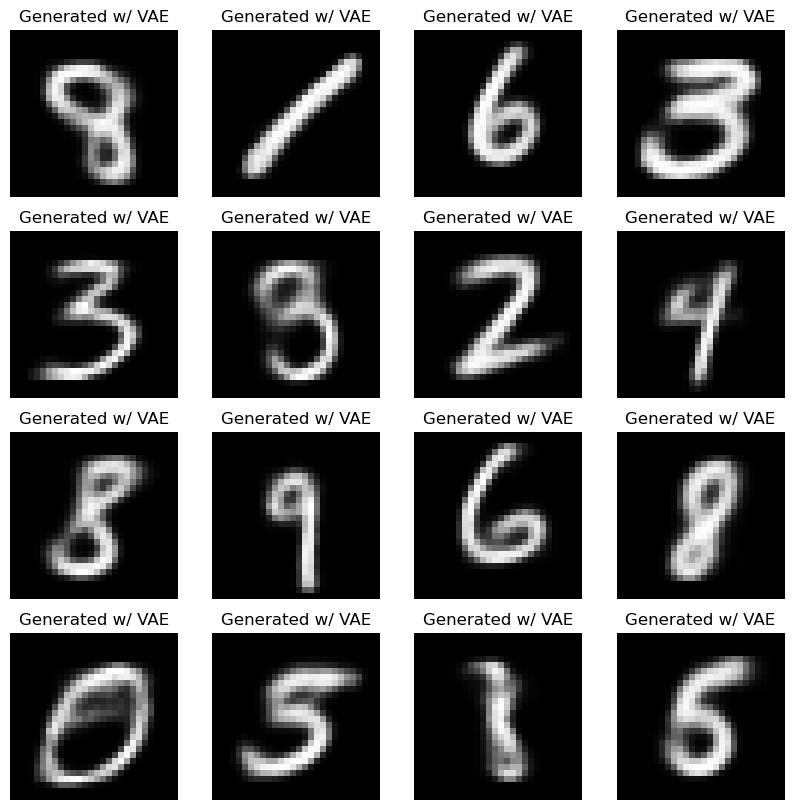

In [9]:
# Generated images with VAE

net.eval()
with torch.no_grad():
    num_generated_images = 16
    x = torch.zeros(num_generated_images, n**2).to(device)
    x_hat = net(x, False)[0]
    print('x_hat',x_hat.size())
    x_hat = x_hat.squeeze().detach().to('cpu')

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(10,10)

i,j,cpt=0,0,0; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,0,1; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,0,2; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,0,3; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=0,1+0,4; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,1+0,5; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,1+0,6; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,1+0,7; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=0,2+0,8; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,2+0,9; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,2+0,10; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,2+0,11; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=0,3+0,12; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,3+0,13; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,3+0,14; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,3+0,15; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')

plt.show()
